# Churn_Probability_Prediction


Анализ оттока клиентов фитнесс-клуба «Культурист-датасаентист» и выработка рекомендаций по удержанию клиентов.

Используемые для анализа данные:
1)Данные на месяц до оттока и факт оттока на определённый месяц. <br>
2)Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента<br>


1. [Загрузка данных, просмотр, предобработка](#1)<br>
2. [Исследовательский анализ данных ](#2)<br>
3. [Модель прогнозирования оттока пользователей](#3)<br>
4. [Кластеризация пользователей](#4)<br>
5. [Визуализация после кластеризации](#6)<br>
6. [Выводы и базовые рекомендации по работе с клиентами](#5)

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

import warnings
warnings.filterwarnings('ignore')


<a name="1"></a>
    
# 1. Загрузка данных, просмотр, предобработка

In [2]:
data=pd.read_csv('gym_churn.csv')
data.head(5)

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

<div style="border:solid silver 1px; padding: 20px"> * Промежуточный вывод: данные полные, пропусков нет 

<a name="2"></a>
# 2. Исследовательский анализ данных

In [4]:
# gосмотрим на датасет: изучите средние значения и стандартные отклонения 
data.describe()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.510250,0.845250,0.486750,0.308500,0.903500,4.681250,0.412250,29.184250,146.943728,4.322750,3.724750,1.879020,1.767052,0.265250
std,0.499957,0.361711,0.499887,0.461932,0.295313,4.549706,0.492301,3.258367,96.355602,4.191297,3.749267,0.972245,1.052906,0.441521
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,27.000000,68.868830,1.000000,1.000000,1.180875,0.963003,0.000000
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,29.000000,136.220159,1.000000,3.000000,1.832768,1.719574,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,31.000000,210.949625,6.000000,5.000000,2.536078,2.510336,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783,1.000000


In [5]:
data['Contract_period'].value_counts()

1     2207
12     960
6      833
Name: Contract_period, dtype: int64

<div style="border:solid silver 1px; padding: 20px"> 
    * Промежуточные выводы 

## Среднее по всем клиентам:

Портрет клиента:<br>
- практически все клиенты живут в райне расположения фитнес-центра (Near_Location)
- около половины клиентов являются сотрудниками компаний-партнеров, т.е. привлечены через  корпоративное привлечение (partner)
- в среднем около 25% клиентов первый раз пришли в клуб по акции "приведи друга" (promo_friends)
- возраст клиентов клуба от 18 до 41 года, средний возраст составляет 29 лет, наибольшее количество посетителей это посетители в возрасте от 27 до 31 года (Age)<br><br>
Данные по контракту:<br>
- более половины контрактов - это контракты на 1 месяц, и примерно по 20 процентов это контракты на 6 и 12 месяцев соответственно. 
- около 25% клиентов посещает групповые занятия (Group_visits)
- средняя частота посещения клуба в неделю за все время (Avg_class_frequency_total,Avg_class_frequency_current_month) - 1-2 раза в неделю, около 25 процентов клиентов клуба посещают клуб более 2 раз в неделю 
- средняя суммарная выручка от других услуг клуба ('Avg_additional_charges_total') - 130-140 (долларов)


Посмотрим как клиенты распределены по признаку оттока

In [6]:
data['Churn'].value_counts()

0    2939
1    1061
Name: Churn, dtype: int64

In [7]:
#посмотрю, каких клиентов больше
data.groupby('Churn').mean()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month
Churn,,,,,,,,,,,,,
0,0.510037,0.873086,0.534195,0.353522,0.903709,5.747193,0.464103,29.976523,158.445715,5.283089,4.711807,2.024876,2.027882
1,0.510839,0.768143,0.355325,0.183789,0.902922,1.728558,0.268615,26.989632,115.082899,1.662582,0.990575,1.474995,1.044546


<div style="border:solid silver 1px; padding: 20px">
* disclaimer: считаю, что Churn=0 - это клиент, а Churn=1 - это отток

<div style="border:solid silver 1px; padding: 20px">

Отличия в портрете клиентов (Клиент vs Отток):<br>
- 53 % привлечены через  корпоративное привлечение  Vs 35 % через корп.привлечение (partner) 
- 35% клиентов первый раз пришли в клуб по акции "приведи друга" (promo_friends) / 18 % промо
- всредний возраст составляет 30 лет/ средний возраст около 27<br><br>
Данные по контракту:<br>
- контрак на 6 месяцев /контракт на 1 месяц. 
- групповые занятия: 46% vs 26 %
- средняя частота посещения клуба в неделю за все время (Avg_class_frequency_total,Avg_class_frequency_current_month) - 2 раза в неделю / 1,5 раза в неделю
- средняя суммарная выручка от других услуг клуба ('Avg_additional_charges_total') - 158/115

Построим столбчатые гистограммы и распределения признаков для тех, кто ушёл (отток) и тех, кто остался (не попали в отток);

In [8]:
data_client=data.query('Churn==0')
data_off=data.query('Churn==1')
X=data.drop('Churn', axis=1)

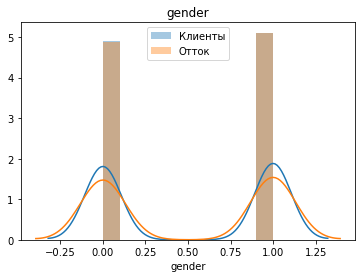

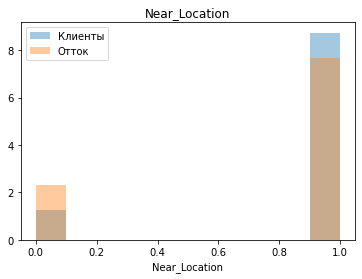

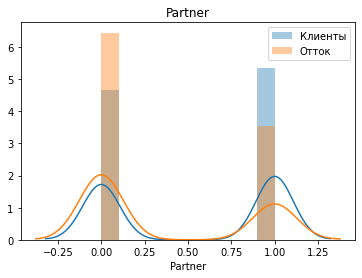

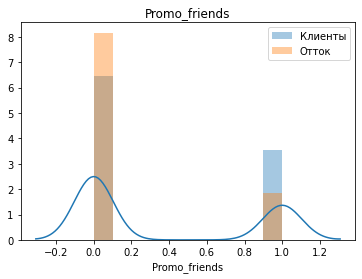

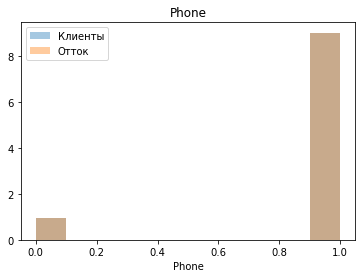

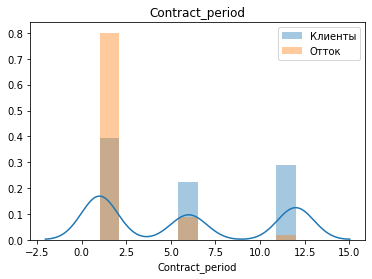

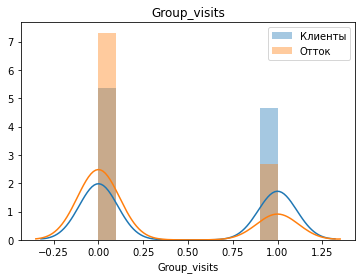

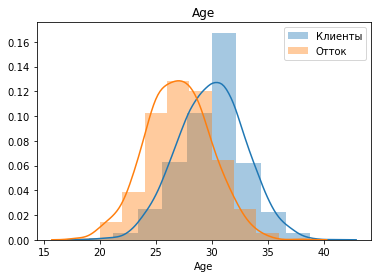

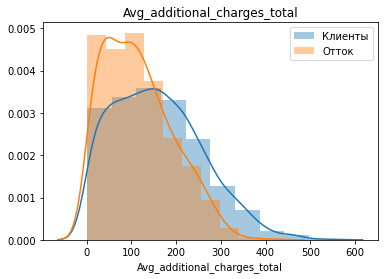

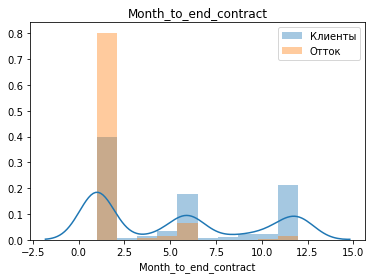

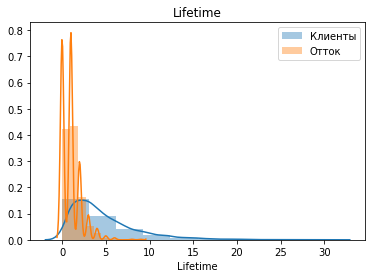

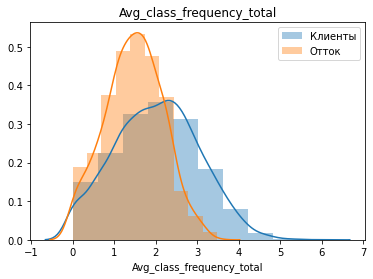

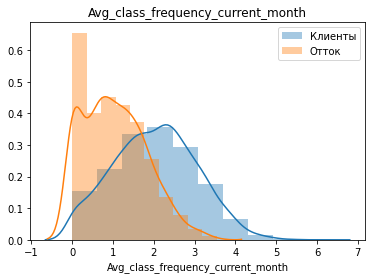

In [9]:
for feature in X.columns:
    sns.distplot(data_client[feature], label='Клиенты', bins = 10);
    sns.distplot(data_off[feature], label='Отток', bins = 10);
    plt.title(feature)
    plt.legend()
    plt.show();

Построим матрицу корреляций и отобразим её.

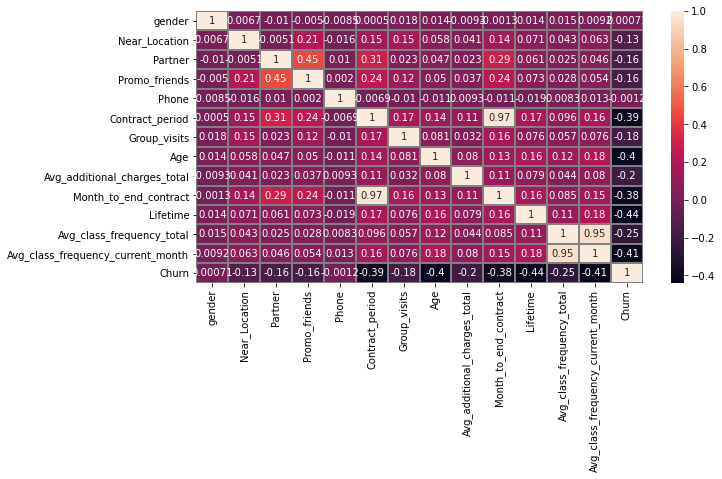

In [10]:
data.corr()
plt.figure(figsize=(10, 5))
sns.heatmap(data.corr(), annot=True, linewidths=1, linecolor='gray')

<div style="border:solid silver 1px; padding: 20px">
* Промежуточный вывод: судя по матрице корреляций, метрики практически не коррелируют друг с другом. Кроем очевидных: длительность контракта  и количество месяцев до его окончания и среднее количество посещений за месяц и в за весь период. 

<a name="3"></a>

# 3. Модель прогнозирования оттока пользователей

Строим модель бинарной классификации пользователей, где целевой признак — факт оттока пользователя в следующем месяце:

In [11]:
#Разбить данные на выборки"
X = data.drop('Churn', axis = 1)
y = data['Churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify = y)

In [12]:
#Обучим модель на train-выборке способом логистической регрессии
model_lr = LogisticRegression(solver='lbfgs', max_iter=1000)
model_lr.fit(X_train,y_train)
#предсказания
predictions_lr = model_lr.predict(X_test)
#Посмотрим метрики accuracy, precision и recall для модели на валидационной выборке.
print('Accuracy: {:.2f}'.format(accuracy_score(y_test, predictions_lr)))
print('Precision: {:.2f}'.format(precision_score (y_test, predictions_lr)))
print('Recall: {:.2f}'.format(recall_score (y_test, predictions_lr)))


Accuracy: 0.93
Precision: 0.89
Recall: 0.85


In [13]:
#Обучите модель на train-выборке алгоритмом "случайный лес"
model_fr = RandomForestClassifier(n_estimators=100)
model_fr.fit(X_train, y_train)
#предсказания
predictions_fr = model_fr.predict(X_test)
#Посмотрим метрики accuracy, precision и recall для модели на валидационной выборке.
print('Accuracy: {:.2f}'.format(accuracy_score(y_test, predictions_fr)))
print('Precision: {:.2f}'.format(precision_score (y_test, predictions_fr)))
print('Recall: {:.2f}'.format(recall_score (y_test, predictions_fr)))


Accuracy: 0.92
Precision: 0.89
Recall: 0.81


<div style="border:solid silver 1px; padding: 20px">
* Промежуточный вывод: Лучше себя показала модель логистической регрессии , потому что показатели ближе к единице

<a name="4"></a>

# 4. Кластеризация пользователей

In [14]:
#стандартизуем данные
scaler = StandardScaler() # создаём объект класса scaler (нормализатор)
x_sc = scaler.fit_transform(X) # обучаем нормализатор


Строим матрицу расстояний функцией linkage() на стандартизованной матрице признаков и рисуем. 

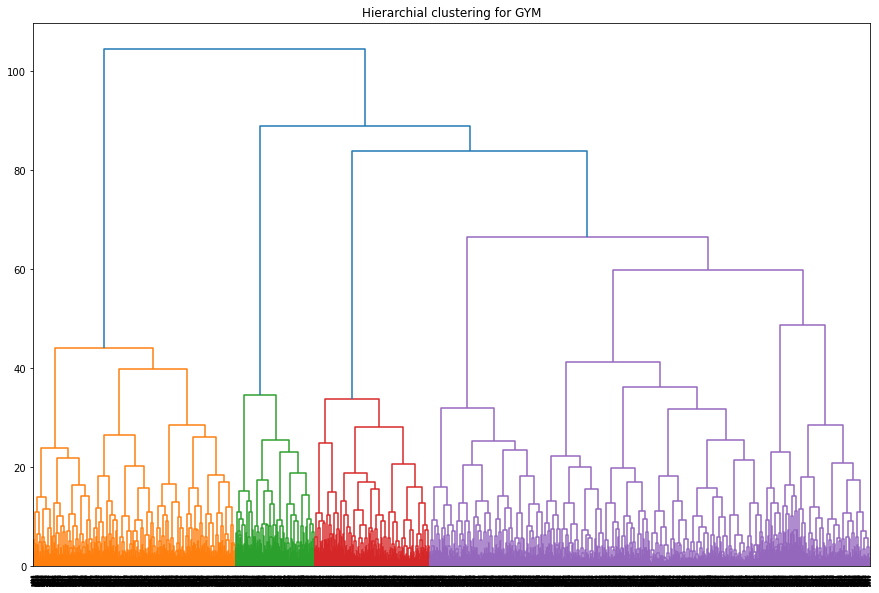

In [15]:
linked = linkage(x_sc, method = 'ward')
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Hierarchial clustering for GYM')
plt.show()

<div style="border:solid silver 1px; padding: 20px">
    На основании дендрограммы делаем вывод, что можно выделить 4 кластера

Обучаем модель кластеризации на основании алгоритма K-Means и спрогнозируем кластеры клиентов. Договорились, что  число кластеров принимаем n=5 (по условию задания).

In [16]:
km = KMeans(n_clusters = 5,random_state=1000)
# прогнозируем кластеры для наблюдений 
labels = km.fit_predict(x_sc)
data['cluster_km'] = labels
 

In [17]:
# выводим статистику по средним значениям признаков по кластеру
data.groupby(['cluster_km']).mean()


,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
cluster_km,,,,,,,,,,,,,,
0,0.483333,1.000000,0.349206,0.238095,1.00000,1.953968,0.339683,28.176984,131.890430,1.861905,2.421429,1.246584,1.012170,0.515079
1,0.564286,0.976190,0.358333,0.233333,0.99881,2.652381,0.477381,30.116667,161.084980,2.447619,4.940476,2.847371,2.844503,0.067857
2,0.501980,0.959406,0.783168,0.574257,1.00000,10.895050,0.541584,29.974257,160.843413,9.956436,4.720792,1.984038,1.976872,0.027723
3,0.495050,0.000000,0.463366,0.079208,1.00000,2.352475,0.215842,28.477228,135.457501,2.198020,2.809901,1.660461,1.477324,0.443564
4,0.522078,0.862338,0.470130,0.306494,0.00000,4.787013,0.425974,29.301299,143.957664,4.475325,3.924675,1.847220,1.716369,0.267532


<div style="border:solid silver 1px; padding: 20px">
* Промежуточный вывод:
Отток выше в кластерах:
Это клиенты у которых осталось в среднем 2 месяца до окончания срока контракта, не посещают групповые занятия, средний возраст 28, пришли не по приглашению друга (сами придумали) или пришли по партнерской программе, но не живут в районе нахождения клуба.

•	Построим распределение признаков для кластеров. Можно ли что-то заметить по ним?

<a name="6"></a>
## NEW. Визуализация после кластеризации

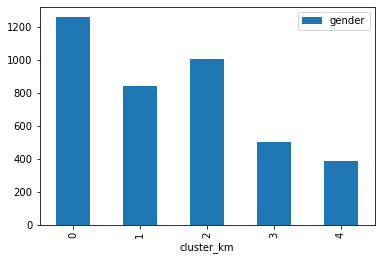

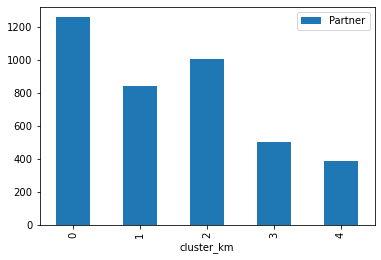

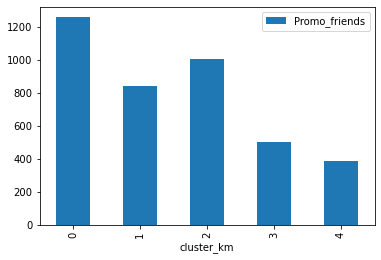

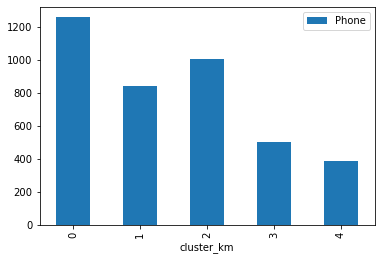

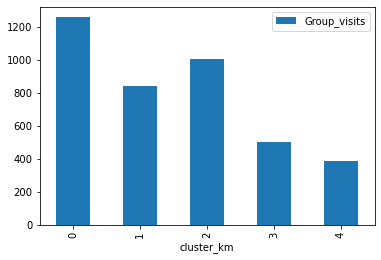

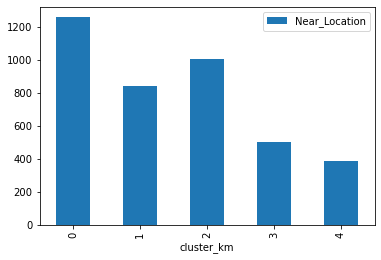

In [18]:
for feature in ('gender','Partner','Promo_friends','Phone','Group_visits','Near_Location'):
        data.groupby('cluster_km').agg({feature:'count'}).plot(kind='bar')


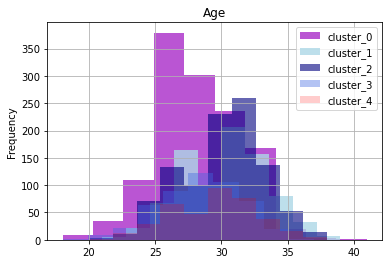

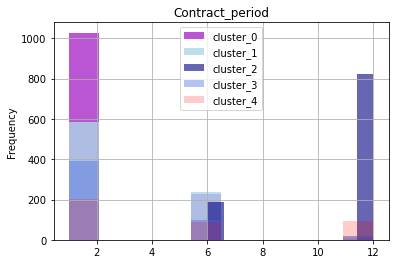

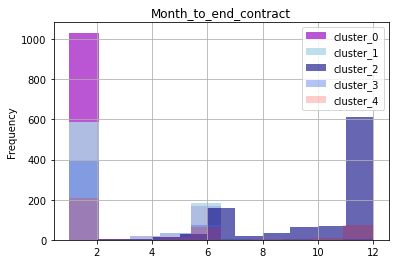

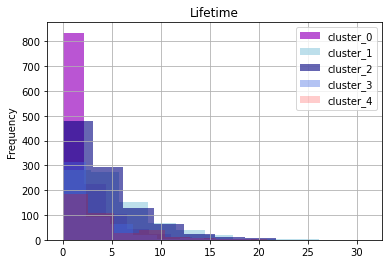

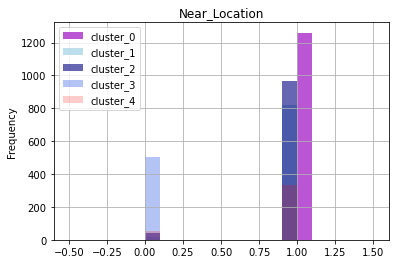

In [19]:
colorlist=('mediumorchid', 'lightblue', 'navy', 'royalblue', 'red')

for feature in ('Age','Contract_period','Month_to_end_contract','Lifetime','Near_Location'):
    a=1
    for i in range(0,5):
        labelname='cluster_'+str(i)
        data.query('cluster_km==@i')[feature].plot(kind='hist',grid=True, color=colorlist[i], label=labelname, alpha=a, title=feature)
        a=a-0.2
    plt.legend()
    plt.show()   


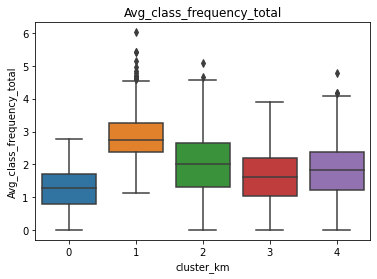

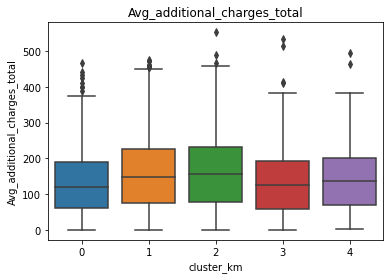

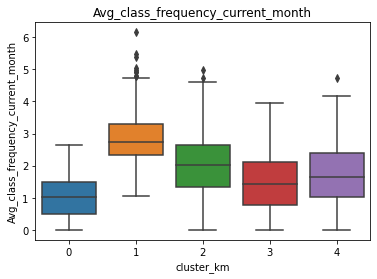

In [20]:
for feature in ('Avg_class_frequency_total','Avg_additional_charges_total','Avg_class_frequency_current_month'):
    sns.boxplot(x="cluster_km", y=feature, data=data);
    plt.title(feature)
    plt.show();

•	Для каждого полученного кластера посчитайте долю оттока (методом groupby()). Отличаются ли они по доле оттока? Какие кластеры склонны к оттоку, а какие — надёжны?

In [21]:
data.groupby(['cluster_km'])['Churn'].mean()

cluster_km
0    0.515079
1    0.067857
2    0.027723
3    0.443564
4    0.267532
Name: Churn, dtype: float64

<div style="border:solid silver 1px; padding: 20px">
* Промежуточный вывод, сделанный ранее не изменен:
Отток выше в 0 и 3 кластере. 
Это клиенты у которых осталось в среднем 2 месяца до окончания срока контракта, не посещают групповые занятия, средний возраст 28, пришли не по приглашению друга (сами придумали) или пришли по партнерской программе, но не живут в районе нахождения клуба.


•	научиться прогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента;
•	сформировать типичные портреты пользователей: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства;
•	проанализировать основные признаки, наиболее сильно влияющие на отток;
•	сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами:
o	1) выделить целевые группы клиентов;
o	2) предложить меры по снижению оттока;
o	3) определить другие особенности взаимодействия с клиентами.


<a name="1"></a>
    
# 5. Выводы и базовые рекомендации



## Обобщенный портрет клиента:<br>
- практически все клиенты живут в райне расположения фитнес-центра (Near_Location)
- около половины клиентов являются сотрудниками компаний-партнеров, т.е. привлечены через  корпоративное привлечение (partner)
- в среднем около 25% клиентов первый раз пришли в клуб по акции "приведи друга" (promo_friends)
- возраст клиентов клуба от 18 до 41 года, средний возраст составляет 29 лет, наибольшее количество посетителей это посетители в возрасте от 27 до 31 года (Age)<br><br>
Данные по контракту:<br>
- более половины контрактов - это контракты на 1 месяц, и примерно по 20 процентов это контракты на 6 и 12 месяцев соответственно. 
- около 25% клиентов посещает групповые занятия (Group_visits)
- средняя частота посещения клуба в неделю за все время (Avg_class_frequency_total,Avg_class_frequency_current_month) - 1-2 раза в неделю, около 25 процентов клиентов клуба посещают клуб более 2 раз в неделю 
- средняя суммарная выручка от других услуг клуба ('Avg_additional_charges_total') - 130-140 (долларов)
<p>
Отличия в портрете клиентов, которые наиболее часто попадают в отток:<br>
- 35 % через корп.привлечение (partner) по сравнению 53% с теми, кто остался членом клуба
- 18 % промо "приведи друга" (promo_friends) 
- средний возраст около 27 (более молодые)<br><br>
Данные по контракту:<br>
- контракт на 1 месяц по сравнению с контрактом на 6 месяцев тех, кто является членом клуба
- посещают групповые занятия:  26 % по сравнению с 46% тех, кто остался
- средняя частота посещения клуба в неделю за все время - 1,5 раза в неделю 
- средняя суммарная выручка от других услуг клуба ('Avg_additional_charges_total') - 115 по сравнению со 158 у членов клуба. 
<p>
По итогам разбиения клиентов на кластеры, выявлено что наибольший отток в двух группах клиентов
<li>Это клиенты у которых осталось в среднем 2 месяца до окончания срока контракта, не посещают групповые занятия, средний возраст 28, пришли не по приглашению друга (сами придумали) или 
<li> пришли по партнерской программе, но не живут в районе нахождения клуба.

<p>

Судя по матрице корреляции, нет признаков прямо влияющих на отток, так как у клуба просто нет данных о жизни клиента вне клуба, которая существенно влияет на отток. Логично, что если изменились приоритеты у человека или он нашел более подходящий клуб или более интересное занятие, то вероятность оттока очень высока, но такими данными клуб не располагает.
<p>
Но среди данных, которыми клуб располагает, есть признаки, которые указывают на то, что клиент скорее всего совсем забросит посещение клуба. Это снижение количества посещений, когда до окончания контракта остается 1-2 месяца
    <p>
Исходя из вышеизложенного можно говорить о том, что нужно сосредоточиться на описанных группах клиентов, показатели пользования клубом которых указывают на возможный отток:<br>
	<li> предлагать акции, связанные с привлечением друзей и знакомых;
	<li> разрабатывать интересные групповые занятия и вовлекать в них клиентов;
	<li> за два месяца до завершения контракта предлагать льготные условия продления
    <li> предлагать доп.услуги
    <li> для клиентов с контрактом 1 месяц, предлагать льготные программы на 6 и 12 месяцев.